## Import Lib, Data Load & Methods

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback
import cv2

In [132]:
!pip install h5py

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Load Data

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [99]:
print (num_classes)
print (num_train)
print (train_features.shape)

10
50000
(50000, 32, 32, 3)


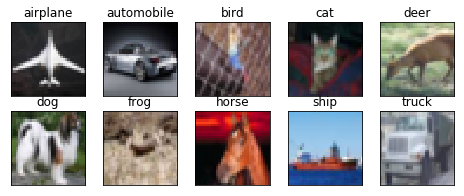

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### Method: plot_model_history

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

### Method: accuracy

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

### Method: get_random_eraser (Cutout)

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

### Class: LR_Finder

In [0]:
import math
from keras.callbacks import LambdaCallback
import keras.backend as K


class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        num_batches = epochs * x_train.shape[0] / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                        batch_size=batch_size, epochs=epochs,
                        callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
            if steps_per_epoch is None:
                try:
                    steps_per_epoch = len(generator)
                except (ValueError, NotImplementedError) as e:
                    raise e('`steps_per_epoch=None` is only valid for a'
                            ' generator based on the '
                            '`keras.utils.Sequence`'
                            ' class. Please specify `steps_per_epoch` '
                            'or use the `keras.utils.Sequence` class.')
            self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(steps_per_epoch))

            # Save weights into a file
            self.model.save_weights('tmp.h5')

            # Remember the original learning rate
            original_lr = K.get_value(self.model.optimizer.lr)

            # Set the initial learning rate
            K.set_value(self.model.optimizer.lr, start_lr)

            callback = LambdaCallback(on_batch_end=lambda batch,
                                      logs: self.on_batch_end(batch, logs))

            self.model.fit_generator(generator=generator,
                                     epochs=epochs,
                                     steps_per_epoch=steps_per_epoch,
                                     callbacks=[callback],
                                     **kw_fit)

            # Restore the weights to the state before model fitting
            self.model.load_weights('tmp.h5')

            # Restore the original learning rate
            K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale('log')

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim)

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
#         best_der_idx = np.argmax(derivatives[n_skip_beginning:-n_skip_end])[0]
        best_der_idx = np.argmax(derivatives[n_skip_beginning:-n_skip_end])
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]

### Method: Get misclassified Images

In [0]:
import random

def get_misclassified_images(model, x_test, y_test, num_images=1):
  y_pred = model.predict(x_test)

  y_pred = np.argmax(np.round(y_pred),axis=1)
  print(y_pred[:9])
  print(y_test[:9])
  
  misclassified_img_idx = list(np.where(y_pred!=y_test)[0])

  print(misclassified_img_idx[:9])
  random_img_idx = random.sample(misclassified_img_idx, num_images)
  
  lst_img_info = []
  
  print("Found %s incorrect labels" % (len(misclassified_img_idx)))

  for img_idx in random_img_idx:
#     img_idx = misclassified_img_idx[i]
    img = X_test[img_idx]

    dct_img_info = {'image': img, 'prediction': y_pred[img_idx], 'ground_truth': y_test[img_idx]}
    lst_img_info.append(dct_img_info)

    
  return lst_img_info


## Methods

### Predict Class: Method that returns class of the image predicted by the model

In [0]:
def predict_class(image, model):
  '''
  image 4D
  '''

  y_pred = model.predict(image)

  # argmax returns the max value in the array
  class_idx = np.argmax(y_pred[0])
  print('predicted class: ', class_idx)
  return class_idx

### Get Convolution Layer Output value

In [0]:
def get_conv_layer_output_value(trained_model, class_output, conv_layer, img_four_dim, num_channels=512):
  """
  num_channels: number of channels in conv_layer selected. 
  Eg- if o/p of conv layerr is 14x14x512, then num_channels would be 512
  """
  grads = K.gradients(class_output, conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([trained_model.input], [pooled_grads, conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([img_four_dim])
  for i in range(num_channels):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  return conv_layer_output_value

### Get Heatmap

In [0]:
def get_heatmap(conv_layer_output_value, axis=1):
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  return heatmap

### Convert nparray to PNG

In [0]:
import cv2

from keras.preprocessing import image
from google.colab.patches import cv2_imshow


def convert_to_png(image_3dim):
  '''
  accepts 3D image
  '''
  converted_img = image.image.array_to_img(image_3dim)
  converted_img.save('gdrive/My Drive/Colab Notebooks/Session9/test1.png')
  loaded_img = cv2.imread('gdrive/My Drive/Colab Notebooks/Session9/test1.png')
  return loaded_img

### Display Image with HeatSigns
method: display_img(image, heatmap)

In [0]:
def display_img_and_heatmap(image, heatmap):
  '''
  accepts png
  '''
  
  heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  
  superimposed_img = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)
  
  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
  plt.imshow(image)
  plt.show()
  plt.imshow(superimposed_img)
  ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])

  plt.show()

In [0]:
def display_img(image, heatmap):
  '''
  accepts png
  '''
  
  heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  
  superimposed_img = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)
  
  fig = plt.figure(figsize=(3,3))
#   ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
#   plt.imshow(image)
#   plt.show()
  plt.imshow(superimposed_img)
#   ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])

  plt.show()

### Wrapper of all the methods - display_test_img_with_heat_signs

In [0]:
def display_test_img_with_heat_signs(test_img, preprocessed_img, trained_model, conv_layer, class_idx, num_channels=512):
  """
  preprocessed_img: 4 dimensional image, with batch size (as model is trained in batches)
  
  """
  class_output = trained_model.output[:, class_idx]
  conv_layer_output_value = get_conv_layer_output_value(trained_model, class_output, conv_layer, preprocessed_img, num_channels)
  
  heatmap = get_heatmap(conv_layer_output_value)
  
  png_img = convert_to_png(test_img)
  
  display_img_and_heatmap(png_img, heatmap)

### display_heatsigns_on_img

In [0]:
def display_heatsigns_on_img(test_img, preprocessed_img, trained_model, conv_layer, class_idx, num_channels=512):
  """
  preprocessed_img: 4 dimensional image, with batch size (as model is trained in batches)
  
  """
  class_output = trained_model.output[:, class_idx]
  conv_layer_output_value = get_conv_layer_output_value(trained_model, class_output, conv_layer, preprocessed_img, num_channels)
  
  heatmap = get_heatmap(conv_layer_output_value)
  
  png_img = convert_to_png(test_img)
  
  display_img(png_img, heatmap)

### Get Image From URL

In [0]:
import io as lib_io
import urllib.request
from PIL import Image


def get_img_from_url(url):
  req = urllib.request.Request(
    url, 
    data=None, 
    headers={'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'
    }
    )

  f = urllib.request.urlopen(req)
  bytes1 = bytearray(f.read())

  img = Image.open(lib_io.BytesIO(bytes1))
  print(type(img))

  img.save('gdrive/My Drive/Colab Notebooks/Session10/temp.png')
  img_from_drive = cv2.imread('gdrive/My Drive/Colab Notebooks/Session10/temp.png')
  return img_from_drive
  
  

### Preprocess Image for VGG

In [0]:
from keras.preprocessing import image

def preprocess_img_for_vgg(img):
  img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  
  return img, x

### Preprocess Image

In [0]:
from keras.preprocessing import image

def preprocess_img(img, dim_x, dim_y):
  img = cv2.resize(img, dsize=(dim_x, dim_y), interpolation=cv2.INTER_CUBIC)
  img4d = image.img_to_array(img)
  img4d = np.expand_dims(img4d, axis=0)
  
  return img, img4d

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [106]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

## Base Code

### Base Accuracy is 83.8% achieved at 95th epoch

### The model above shows some amount of overfitting and this would require some kind of regularization.
### Re-Running the model with below changes 
1. Using Image Normalization
2. Making use of Batch Normalization
3. Making use of L2 Regularizer
4. Properly using Dropout
5. Removed Dense layers
6. Overall reduced number of parameters from 1,172,410 to 290,090

### Results: Achieved a better accuracy of 84.33 % in just 15th Epoch. Ran the model further and achieved 86.36 % in 45th Epoch & 87.53 % in 89th Epoch

In [13]:
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()


print('Statistics train=%.3f (%.3f), test=%.3f (%.3f)' % (trainX.mean(), trainX.std(), testX.mean(), testX.std()))

# create generator that centers pixel values
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate the mean on the training dataset
datagen.fit(trainX)
#print('Data Generator mean=%.3f, std=%.3f' % (datagen.mean, datagen.std))

# demonstrate effect on a single batch of samples
iterator = datagen.flow(trainX, trainy, batch_size=128)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

# demonstrate effect on entire training dataset
iterator = datagen.flow(trainX, trainy, batch_size=len(trainX), shuffle=False)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

Statistics train=120.708 (64.150), test=121.529 (64.061)
(128, 32, 32, 3) 0.013107389 1.0013419
(50000, 32, 32, 3) -1.6605131e-06 1.0000001


In [0]:
iterator1 = datagen.flow(testX, testy, batch_size=len(testX), shuffle=False)
batch_testX, batch_testy = iterator1.next()

X_train = batchX
X_test = batch_testX

y_train=batchy
y_test=batch_testy
                        

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [0]:
def func_model():

  # Define the model
  model1 = Sequential()
  model1.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
  model1.add(Activation('relu'))
  model1.add(BatchNormalization())

  model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
  model1.add(Activation('relu'))
  model1.add(BatchNormalization())

  model1.add(MaxPooling2D(pool_size=(2, 2)))
  model1.add(Dropout(0.2))

  model1.add(Convolution2D(32, 1, 1))


  model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
  model1.add(Activation('relu'))
  model1.add(BatchNormalization())

  model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
  model1.add(Activation('relu'))
  model1.add(BatchNormalization())

  model1.add(MaxPooling2D(pool_size=(2, 2)))
  model1.add(Dropout(0.3))

  model1.add(Convolution2D(32, 1, 1))


  model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
  model1.add(Activation('relu'))
  model1.add(BatchNormalization())

  model1.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
  model1.add(Activation('relu'))
  model1.add(BatchNormalization())

  model1.add(MaxPooling2D(pool_size=(2, 2)))
  model1.add(Dropout(0.5))

  model1.add(Convolution2D(10, 1, 1))

  model1.add(AveragePooling2D(pool_size = (4,4)))
  model1.add(Flatten())


  model1.add(Activation('softmax'))
  
  return model1

In [127]:
model1 = func_model()

# Compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., pad

In [110]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_57 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_58 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 16, 16, 64)        0         
__________

### Total params: 455,370

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model1.fit_generator(datagen.flow(X_train, Y_train, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (X_test, Y_test), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model1))

### Achieved 86.36 % in 45th Epoch.

### Ran for 50 more epochs and achieved 87.53 % as shown below in 39th epoch (total 89th epoch)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model1.fit_generator(datagen.flow(X_train, Y_train, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (X_test, Y_test), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model1))

## Assignment

### Get BEST Learning Rate

The best learning rate found is 0.017600462

In [128]:
model1 = func_model()

# Compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., pad

In [118]:
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                            preprocessing_function=get_random_eraser(v_l=0, v_h=1))

lr_finder = LRFinder(model1)
bs = 64
epoch = 5

# train the model
start = time.time()
# Train the model


model_info = lr_finder.find_generator(datagen.flow(X_train, Y_train, batch_size = bs),
                                      start_lr=0.0001, end_lr=1, epochs=5,
                                 samples_per_epoch = train_features.shape[0],
                                 validation_data=(X_test, Y_test), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<keras_pre..., epochs=5, steps_per_epoch=781, callbacks=[<keras.ca..., validation_data=(array([[[..., verbose=1)`


Epoch 1/5
667/781 [========================>.....] - ETA: 8s - loss: 1.8866 - acc: 0.3595Model took 64.69 seconds to train
Accuracy on test data is: 10.00


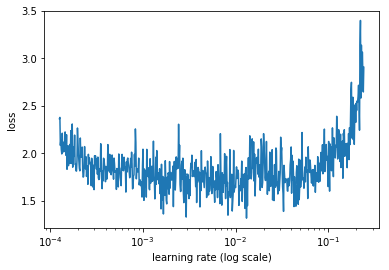

In [120]:
# Plot the loss, ignore 20 batches in the beginning and 5 in the end
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

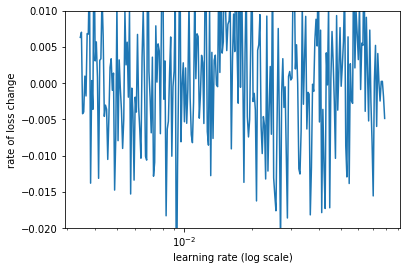

In [119]:
lr_finder.plot_loss_change(sma=25, n_skip_beginning=300, n_skip_end=100, y_lim=(-0.02, 0.01))

In [124]:
sma = 25
n_skip_beginning = 300
n_skip_end = 100

best_lr = lr_finder.get_best_lr(sma, n_skip_beginning=n_skip_beginning, n_skip_end=n_skip_end)
print('The best Learning Rate is: ', best_lr)

The best Learning Rate is:  0.017600462


### SGD with momentum


In [144]:
from keras.optimizers import SGD

model_sgd = func_model()

sgd = SGD(lr=0.017600462, momentum=0.9)
model_sgd.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., pad

In [0]:
from keras.callbacks import ModelCheckpoint

checkpoint_path = "gdrive/My Drive/Colab Notebooks/Session11/bestNW.hdf5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

### Train for 100 Epochs  & Show Training and Test Accuracy curves

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=0, callbacks=[<keras.ca..., steps_per_epoch=195, epochs=100)`
  



Epoch 00001: val_acc improved from -inf to 0.16570, saving model to gdrive/My Drive/Colab Notebooks/Session11/bestNW.hdf5

Epoch 00002: val_acc did not improve from 0.16570

Epoch 00003: val_acc improved from 0.16570 to 0.20560, saving model to gdrive/My Drive/Colab Notebooks/Session11/bestNW.hdf5

Epoch 00004: val_acc did not improve from 0.20560

Epoch 00005: val_acc did not improve from 0.20560

Epoch 00006: val_acc did not improve from 0.20560

Epoch 00007: val_acc did not improve from 0.20560

Epoch 00008: val_acc improved from 0.20560 to 0.22120, saving model to gdrive/My Drive/Colab Notebooks/Session11/bestNW.hdf5

Epoch 00009: val_acc did not improve from 0.22120

Epoch 00010: val_acc did not improve from 0.22120

Epoch 00011: val_acc did not improve from 0.22120

Epoch 00012: val_acc improved from 0.22120 to 0.22130, saving model to gdrive/My Drive/Colab Notebooks/Session11/bestNW.hdf5

Epoch 00013: val_acc improved from 0.22130 to 0.23660, saving model to gdrive/My Drive/Col

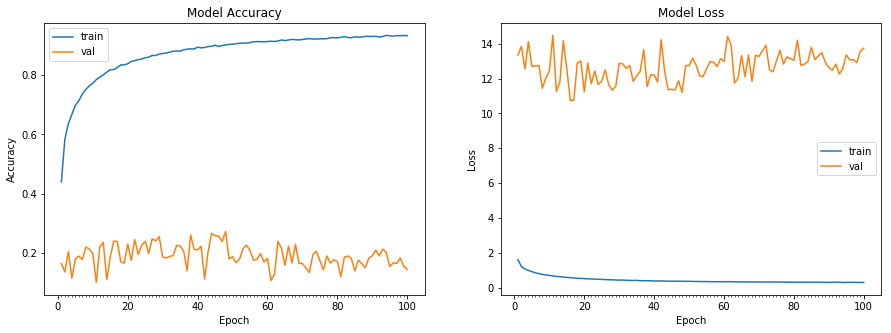

Accuracy on test data is: 14.60


In [146]:
epoch = 100
bs = 256

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                            preprocessing_function=get_random_eraser(v_l=0, v_h=1))


# train the model
start = time.time()
# Train the model
model_info = model_sgd.fit_generator(datagen.flow(X_train, Y_train, batch_size = bs),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = epoch, 
                                 validation_data = (X_test, Y_test), verbose=0, callbacks=[checkpoint])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)

# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model_sgd))



In [0]:
model_sgd.summary()

### Run GradCAM on the any 25 misclassified images. Make sure you mention what is the prediction and what was the ground truth label.

[7 7 7 7 7 7 7 7 7]
[3 8 8 0 6 6 1 6 3]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
Found 8539 incorrect labels
Predicted: horse......Ground Truth: truck


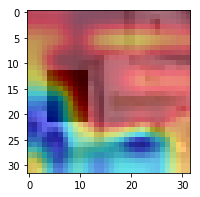

Predicted: horse......Ground Truth: airplane


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


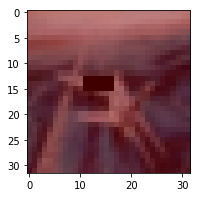

Predicted: horse......Ground Truth: cat


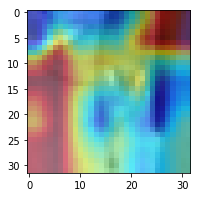

Predicted: horse......Ground Truth: dog


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


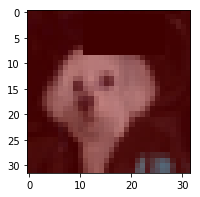

Predicted: horse......Ground Truth: bird


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


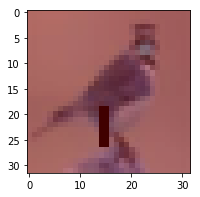

Predicted: horse......Ground Truth: dog


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


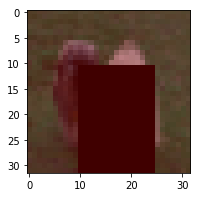

Predicted: horse......Ground Truth: truck


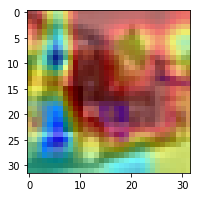

Predicted: horse......Ground Truth: airplane


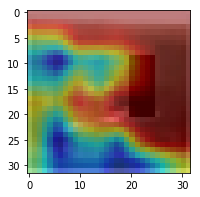

Predicted: horse......Ground Truth: dog


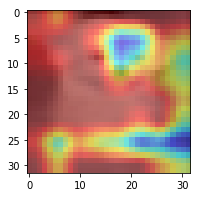

Predicted: horse......Ground Truth: dog


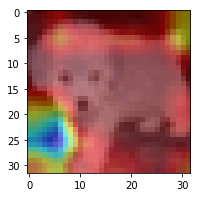

Predicted: horse......Ground Truth: airplane


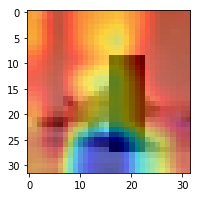

Predicted: horse......Ground Truth: cat


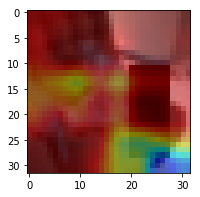

Predicted: horse......Ground Truth: truck


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


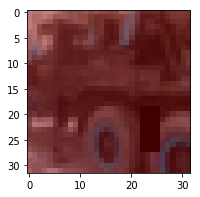

Predicted: horse......Ground Truth: dog


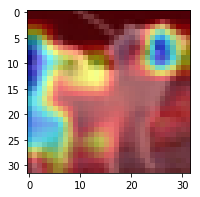

Predicted: horse......Ground Truth: frog


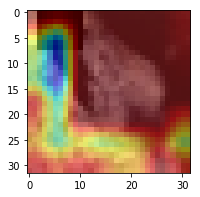

Predicted: horse......Ground Truth: dog


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


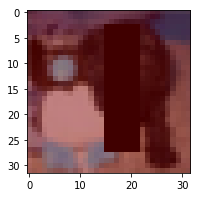

Predicted: horse......Ground Truth: truck


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


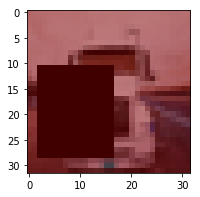

Predicted: horse......Ground Truth: frog


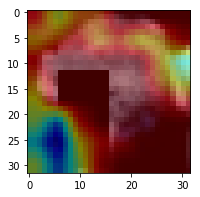

Predicted: horse......Ground Truth: bird


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


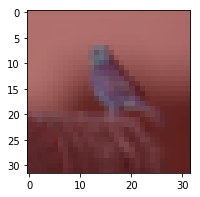

Predicted: horse......Ground Truth: frog


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


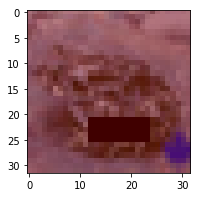

Predicted: horse......Ground Truth: frog


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


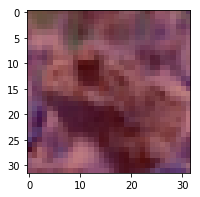

Predicted: horse......Ground Truth: ship


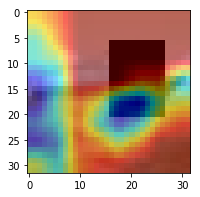

Predicted: horse......Ground Truth: automobile


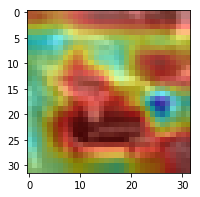

Predicted: horse......Ground Truth: cat


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


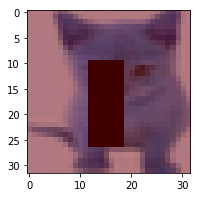

Predicted: horse......Ground Truth: automobile


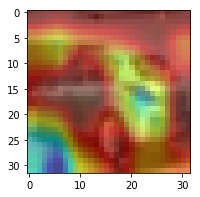

In [206]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

argmax_y_test = np.argmax(np.round(Y_test),axis=1)

lst_misclassified_img_details = get_misclassified_images(model_sgd, X_test, argmax_y_test, num_images=25)

conv_layer = model_sgd.get_layer('conv2d_152')

for dct_img_details in lst_misclassified_img_details:
  img = dct_img_details['image']
  predicted_idx = dct_img_details['prediction']
  ground_truth = dct_img_details['ground_truth']
  print('Predicted: {}......Ground Truth: {}'.format(class_names[predicted_idx], class_names[ground_truth]))
  img, preprocessed_img = preprocess_img(img, 32, 32)
  
  display_heatsigns_on_img(img, preprocessed_img, model_sgd, conv_layer, predicted_idx, num_channels=256)